In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"amirhosseinfeiz","key":"5228cdd8a111ac93b8ddde7d70369a5f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/mias-mammography

mias-mammography.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip 'mias-mammography'

Archive:  mias-mammography.zip
replace Info.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Find the direction of dataset
'''import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

"import numpy as np\nimport pandas as pd\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [ ]:
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random # for visualization
print('Libraries Imported')

Libraries Imported


In [ ]:
path = 'all-mias/'

an example of image path

../input/mias-mammography/all-mias/mdb001.pgm

## Read Data

In [ ]:
import pandas as pd

print("reading dataframe")
info=pd.read_csv("Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)

reading dataframe


In [ ]:
info

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [ ]:
info.dropna(subset = ["SEVERITY"], inplace=True)

info.reset_index(inplace = True)
info

,index,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,4,mdb005,F,CIRC,B,477.0,133.0,30.0
3,5,mdb005,F,CIRC,B,500.0,168.0,26.0
4,10,mdb010,F,CIRC,B,525.0,425.0,33.0
...,...,...,...,...,...,...,...,...
118,281,mdb274,F,MISC,M,127.0,505.0,123.0
119,297,mdb290,D,CIRC,B,337.0,353.0,45.0
120,319,mdb312,F,MISC,B,240.0,263.0,20.0
121,321,mdb314,F,MISC,B,518.0,191.0,39.0


In [ ]:
info = info.drop([3], axis=0)
info.reset_index(inplace = True)
info

,level_0,index,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,0,0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,1,1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,2,4,mdb005,F,CIRC,B,477.0,133.0,30.0
3,4,10,mdb010,F,CIRC,B,525.0,425.0,33.0
4,5,12,mdb012,F,CIRC,B,471.0,458.0,40.0
...,...,...,...,...,...,...,...,...,...
117,118,281,mdb274,F,MISC,M,127.0,505.0,123.0
118,119,297,mdb290,D,CIRC,B,337.0,353.0,45.0
119,120,319,mdb312,F,MISC,B,240.0,263.0,20.0
120,121,321,mdb314,F,MISC,B,518.0,191.0,39.0


In [ ]:
# taking the images filenames in to dictionary
ids = {}
for i in range(len(info)):
    ids[i] = info.REFNUM[i]
#ids

In [ ]:
info['CLASS'].unique()

array(['CIRC', 'MISC', 'ASYM', 'ARCH', 'SPIC', 'CALC'], dtype=object)

## Turning our outputs B-M to 1-0

In [ ]:
import numpy as np

# Turning our outputs B-M to 1-0
label = []
for i in range(len(info)):
    if info.CLASS[i] == 'CIRC':
        label.append(0)
    if info.CLASS[i] == 'MISC':
        label.append(1)
    if info.CLASS[i] == 'ASYM':
        label.append(2)
    if info.CLASS[i] == 'ARCH':
        label.append(3)
    if info.CLASS[i] == 'SPIC':
        label.append(4)
    if info.CLASS[i] == 'CALC':
        label.append(5)

In [ ]:
label = np.array(label)

In [ ]:
label.shape

(122,)

In [ ]:
# define the every images filepaths in to list
img_name = []

for i in range(len(label)):
        img_name.append(path + info.REFNUM[i]+ '.pgm')

In [ ]:
img_name = np.array(img_name)

In [ ]:
#print(img_name)
print(f'image addres amount {img_name.shape}')

image addres amount (122,)


## view image random images

In [ ]:
info['CLASS'].unique()

array(['CIRC', 'MISC', 'ASYM', 'ARCH', 'SPIC', 'CALC'], dtype=object)

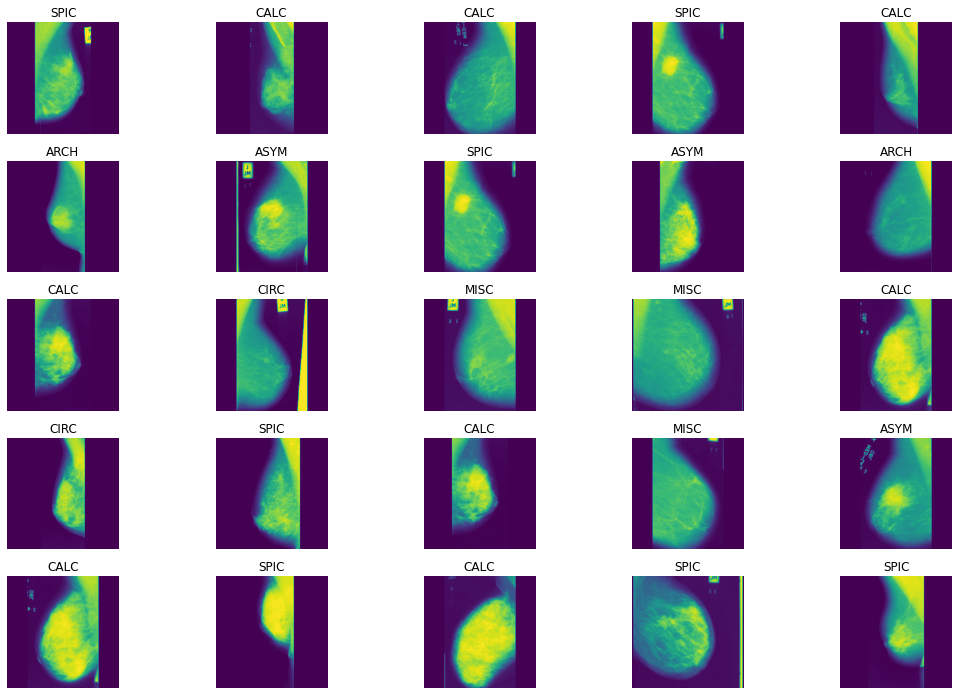

In [ ]:
# view image random images
def view_25_random_image():
    fig = plt.figure(figsize = (15, 10))
    for i in range(25):
        rand = random.randint(0,len(label))
        ax = plt.subplot(5, 5, i+1)
    
        img = cv2.imread(img_name[rand], 0)
        img = cv2.resize(img, (256,256))
        if label[rand] == 0:
            plt.title('CIRC')
        if label[rand] == 1:
            plt.title('MISC')
        if label[rand] == 2:
            plt.title('ASYM')
        if label[rand] == 3:
            plt.title('ARCH')
        if label[rand] == 4:
            plt.title('SPIC')
        if label[rand] == 5:
            plt.title('CALC')
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img)
    fig.savefig('random_25_image_fig.png')

random_images = view_25_random_image()

## read Images and labels. and augmentation of images

In [ ]:
img_path = []
last_label = []
for i in range(len(img_name)):
    
    img = cv2.imread(img_name[i], 0)
    img = cv2.resize(img, (224,224))
    rows, cols= img.shape
    for angle in range(360):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (224, 224))
            img_path.append(img_rotated)
            if label[i] == 0:
                last_label.append(0)
            if label[i] == 1:
                last_label.append(1)
            if label[i] == 2:
                last_label.append(2)
            if label[i] == 3:
                last_label.append(3)
            if label[i] == 4:
                last_label.append(4)
            if label[i] == 5:
                last_label.append(5)

In [ ]:
last_label = np.array(last_label)
img_path = np.array(img_path)

## split train and test set

In [ ]:
# split train and test set
x_train, x_test, y_train, y_test = train_test_split(img_path, last_label, test_size = 0.2, random_state = 42)

In [ ]:
len(x_train),len(x_test),len(y_train),len(y_test)

(35136, 8784, 35136, 8784)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [ ]:
x_train.shape

(35136, 224, 224)

In [ ]:
x_test.shape

(8784, 224, 224)

In [ ]:
from keras.utils import np_utils
nClasses = 6
y_train=np_utils.to_categorical(y_train, nClasses)
y_test=np_utils.to_categorical(y_test, nClasses)

In [ ]:
(a,b,c)=x_train.shape # (35136, 224, 224)
x_train = np.reshape(x_train, (a, b, c, 1)) # 1 for gray scale
(a, b, c)=x_test.shape
x_test = np.reshape(x_test, (a, b, c, 1))

## Build a Model

In [ ]:

def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(224, 224, 1)))
    model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
    model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
    model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
    model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
  
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(6, activation='softmax'))
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 51, 51, 128)       7

## Define Callbacks

In [ ]:

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=0,restore_best_weights=True, verbose=1)

check_point_filepath = './'

model_check_point = ModelCheckpoint(filepath =check_point_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                    save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(x_train,
                 y_train,
                 validation_split=0.2,
                 epochs=100,
                 batch_size=32,
                 callbacks=[early_stop, model_check_point])



Epoch 1/100
879/879 [==============================] - 136s 115ms/step - loss: 1.7299 - accuracy: 0.2809 - val_loss: 1.3920 - val_accuracy: 0.4570

Epoch 00001: val_loss improved from inf to 1.39203, saving model to ./
INFO:tensorflow:Assets written to: ./assets
Epoch 2/100
879/879 [==============================] - 101s 115ms/step - loss: 1.3091 - accuracy: 0.4888 - val_loss: 0.8478 - val_accuracy: 0.6968

Epoch 00002: val_loss improved from 1.39203 to 0.84776, saving model to ./
INFO:tensorflow:Assets written to: ./assets
Epoch 3/100
879/879 [==============================] - 101s 114ms/step - loss: 0.7971 - accuracy: 0.7026 - val_loss: 0.3379 - val_accuracy: 0.8819

Epoch 00003: val_loss improved from 0.84776 to 0.33788, saving model to ./
INFO:tensorflow:Assets written to: ./assets
Epoch 4/100
879/879 [==============================] - 101s 115ms/step - loss: 0.3834 - accuracy: 0.8643 - val_loss: 0.1419 - val_accuracy: 0.9519

Epoch 00004: val_loss improved from 0.33788 to 0.14191,

the model looks overfitting. those may be the reason
* we don't have enough data
* We enlarge multiple images with the same image

In [ ]:
model.save('mias_mammography_object_detection.h5')

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

print(model.predict(x_test))

275/275 [==============================] - 10s 35ms/step - loss: 0.0274 - accuracy: 0.9942
Test_loss_value = 0.027406081557273865
test_accuracy = 0.994193971157074
[[1.54762994e-03 8.63887966e-01 1.33616298e-01 1.74907848e-06
  8.50942801e-04 9.54146963e-05]
 [2.51247235e-11 5.64930724e-09 9.71886394e-09 3.64891584e-08
  1.84552773e-05 9.99981523e-01]
 [2.43833025e-08 1.38275187e-08 8.94139428e-03 9.89904344e-01
  9.48410830e-04 2.05769247e-04]
 ...
 [7.17332282e-09 9.41348345e-13 2.47748453e-08 8.26543209e-11
  5.87485374e-05 9.99941230e-01]
 [1.21681696e-04 1.97383488e-04 9.53124404e-01 2.62509715e-02
  3.23122367e-04 1.99825130e-02]
 [4.17551026e-04 1.00267600e-04 1.56832117e-04 9.84397233e-01
  3.59176542e-03 1.13363145e-02]]


## Let's Visualize our result

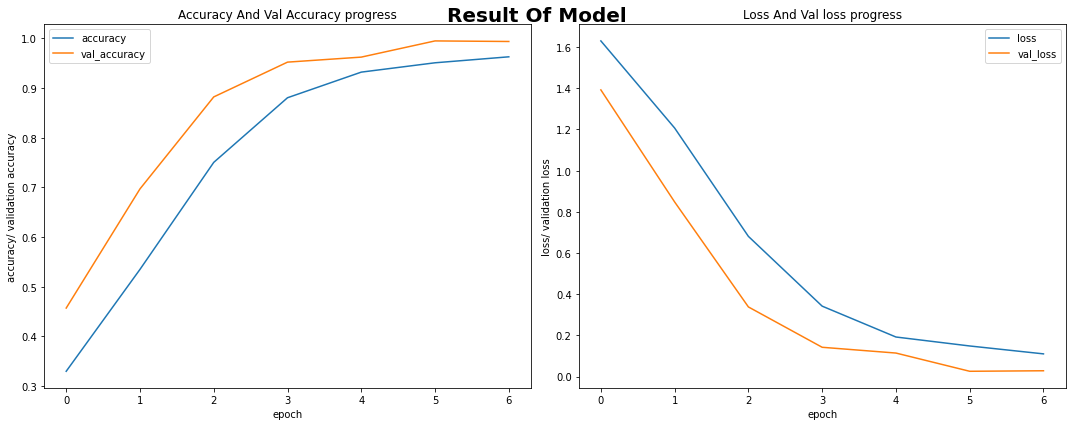

In [ ]:

def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(hist.history['accuracy'],hist.history['val_accuracy'], hist.history['loss'], hist.history['val_loss'])

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
x_test.shape

In [ ]:
x_test = np.array(x_test)
x_test = x_test.astype('float32')

In [ ]:
info['CLASS'].unique()

array(['CIRC', 'MISC', 'ASYM', 'ARCH', 'SPIC', 'CALC'], dtype=object)

In [ ]:
labels = ['CIRC','MISC','ASYM','ARCH','SPIC','CALC']

for i in range(10):
  '''plt.imshow(x_test[i])
  plt.xticks([])
  plt.yticks([])
  plt.show()'''

  results = np.argmax(model.predict(x_test[i].astype(np.float64)[np.newaxis, :, :, :]))
  number = np.argmax(y_test[i])

  print('True label: {}'.format(labels[number]))
  print('prediction: {}'.format(labels[results]))

True label: MISC
prediction: MISC
True label: CALC
prediction: CALC
True label: ARCH
prediction: ARCH
True label: SPIC
prediction: SPIC
True label: CIRC
prediction: CIRC
True label: MISC
prediction: MISC
True label: CALC
prediction: CALC
True label: MISC
prediction: MISC
True label: CIRC
prediction: CIRC
True label: CALC
prediction: CALC
